# 랭그래프 LangGraph
![](https://langchain-ai.github.io/langgraph/static/wordmark_dark.svg)

**랭그래프LangGraph**는 랭체인을 개발한 LangChain.inc에서 개발한 **에이전트 오케스트레이션 프레임워크**. 

기존 선형적인 체인 구조를 넘어서, **복잡한 다중 에이전트 시스템**과 **상태를 가진 워크플로**를 구축할 수 있도록 설계. 

클라나Klarna, 리플릿Replit, 우버, 일레스틱 Elastic과 같은 대기업들이 프로덕션 환경에서 사용하고 있으며, 
복잡한 워크플로와 오래 걸리는 작업을 처리하는 데 최적화되어 있다.

- 공식메인: https://www.langchain.com/langgraph
- 공식Document: https://docs.langchain.com/oss/python/langchain/overview


# 1.그래프(Graph) 자료구조의 이해

랭그래프를 제대로 이해하려면 먼저 그래프 Graph 자료구조에 대한 기본 개념을 알아야 합니다. 

## 노드 & 에지

그래프(Graph)는 **노드(Node)** 와 **에지(Edge)** 로 구성된 자료구조로, 객체 간의 **관계**를 표현하는 데 매우 효과적입니다. 

※자료구조에선 노드를 버텍스(Vertex), 에지를 아크(Arc) 라고도 표기하기도 함.

![](https://dz2cdn1.dzone.com/storage/temp/13817670-figure-1.png)


![](https://blog.kakaocdn.net/dna/p30EJ/btqAaV5x253/AAAAAAAAAAAAAAAAAAAAAK_3AH9Ze7guwlBCrLD2qXxLCjMn9h0vdZ3Yfxzfm2d7/img.png?credential=yqXZFxpELC7KVnFOS48ylbz2pIh7yKj8&expires=1767193199&allow_ip=&allow_referer=&signature=Xk0U2%2BS9%2FvgELvj4%2FyGxXOiDcRQ%3D)

## Directed vs. Undirected
그래프는 방향성에 따라 방향 그래프 Directed Graph 와 무방향 그래프 Undirected Graph 로 나뉩니다. 

![](https://www.chhitizbuchasia.com/static/9a65c24a1cc442a1c313eee8f8796494/f73a1/graph-direction.png)

**랭그래프는 방향 그래프를 기반**으로 합니다. 이는 작업의 흐름이 특정 방향을 가지기 때문입니다. 
예를 들어 A 작업이 완료된 후 B 작업이 실행되는 것을 그래프로 명확하게 표현할 수 있습니다.


## Cyclic vs. Acyclic 
![](https://i.imgur.com/2z9J2E5.png)
그래프의 또 다른 중요한 특성은 순환(cycle)의 존재 여부입니다. 
순환이 없는 그래프를 **DAG(Directed Acyclic Graph)** 라고 하며, 많은 워크플로 시스템이 DAG만을 이용합니다. 

랭그래프는 __순환이 있는 그래프도 사용할 수 있습니다__. 이를 통해 조건이 만족될 때까지 특정 작업을 반복하거나, 
이전 단계로 돌아가는 등의 복잡한 패턴을 구현할 수 있습니다.

# 2.랭그래프의 핵심 개념
랭그래프에서 가장 중요한 개념은 상태 **state, 노드, 에지** 다

## 상태
상태는 그래프 실행 과정에서 지속적으로 유지되는 데이터로 각 노드가 실행될 때마다 읽고 쓸 수 있습니다. 
이는 단순한 변수 전달을 넘어 전체 워크플로의 컨텍스트를 관리하는 중앙 저장소 역할을 합니다. 
상태는 일반적으로 TypedDict나 Pydantic 모델로 정의되어 타입 안정성을 보장합니다.

![](https://blog.kakaocdn.net/dna/b8M326/btsKHa4NK5y/AAAAAAAAAAAAAAAAAAAAAJXzhsnCg-KnkTf7m45pGDMVkYbF6qYf9unPeKw5G1Hf/img.png?credential=yqXZFxpELC7KVnFOS48ylbz2pIh7yKj8&expires=1767193199&allow_ip=&allow_referer=&signature=uoSeR1p0JrS56Fw5HddRSi7hEQg%3D)


## 노드
'노드' 는 그래프의 기본 실행 단위입니다.  각 노드는 특정 작업을 수행하는 함수나 에이전트를 나타내며, 다음과 같은 특징을 가집니다.

- 현재 상태를 입력으로 받음
- 특정 작업을 수행(LLM 호출, 데이터 처리, 외부 API 호출 등)
- 업데이트된 상태를 반환

노드는 순수함수일 수도 있고, 부수 효과side Effects를 가질 수도 있습니다. 예를 들어 DB에 쓰기 작업을 하거나 외부 API를 호출할 수도 있습니다.

## 에지
에지는 노드 간의 연결을 정의하며, 실행 흐름을 제어합니다. 랭그래프는 두 가지 유형의 에지를 지원합니다.

1. 일반 에지 : 항상 같은 경로로 진행

2. 조건부 에지: 상태에 따라 다른 노드로 분기

조건부 에지는 동적 라우팅을 가능하게 하여, 런타임에 실행 경로를 결정할 수 있습니다. 
이를 사용하여 AI 에이전트가 상황에 따라 다른 전략을 선택하게 하거나, 오류 처리 로직을 구현하는 데 유용합니다.

* 일반에지는 실선으로 표현하고, 조건부 에지는 점선으로 표기하기도 한다
![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdna%2FbmQ1V0%2FbtsO9pWxNrk%2FAAAAAAAAAAAAAAAAAAAAAPPkwBPstxlJ70mB38Az5m_RNtNo8VeKvpMnhv6dtkTE%2Fimg.png%3Fcredential%3DyqXZFxpELC7KVnFOS48ylbz2pIh7yKj8%26expires%3D1767193199%26allow_ip%3D%26allow_referer%3D%26signature%3DfbcGKh3RNPXIQyz2odx2K6DFm9Q%253D)


# 3. Hello LangGraph

In [1]:
# from tkinter import Image
from typing import Dict, Any
from langgraph.graph import StateGraph, START, END
from pydantic import BaseModel, Field
from IPython.display import Image

In [2]:
# 다음과 같은 흐름으로 구성된 랭그래프 예제를 만들어봅시다.

# [시작] --> [Greeting] --> [Processing] --> [종료]

## 워크플로우 단계 정의

In [3]:
class WorkflowStep:
    GREETING = 'GREETING'      # 인사말을 생성하는 단계
    PROCESSING = 'PROCESSING'  # 생성된 이사말을 처리하고 메세지를 생성하는 단계

## 그래프의 '상태 (state)' 정의 

In [4]:
# State 즉 그래프의 상태는 각 노드마다 참조가 가능한 전체 워크플로 상의 컨텍스트라고 볼 수 있습니다. 
class GraphState(BaseModel):
    name: str = Field(default="", description='사용자 이름')
    greeting: str = Field(default="", description='생성된 이사말')
    processed_message: str = Field(default="", description="처리된 최종 메세지")


## 노드 정의

In [5]:
# 첫번째 노드 함수
# state 를 객체를 받아서 인사말을 생성하고 리턴.
# 'greeting' 값을 업데이트 하도록 dict 리턴 <- 랭그래프 실행하게되면 자동적으로 동작함.
def generate_greeting(state: GraphState) -> Dict[str, Any]:
    name = state.name or '아무개'
    greeting = f'안녕하세요, {name}님'
    print(f'[generate_greeting] 인사말 생성: {greeting}')
    return {"greeting": greeting}

In [13]:
# 두번째 노드 함수
# 인사말을 처리하고 최종 메세지 생성.
def process_message(state: GraphState) -> Dict[str, Any]:
    greeting = state.greeting
    processed_message = f'{greeting} LangGraph 와의 첫만남 축하합니다'
    print(f'[process_message] 최종메세지: {processed_message}')
    return {'processed_message': processed_message}

## 그래프 생성
aka. pipeline, workflow ...

In [14]:
# StateGraph 로 상태를 가진 그래프 객체 정의.
def create_hello_graph():
    workflow = StateGraph(GraphState)

    # 노드 추가
    workflow.add_node(WorkflowStep.GREETING, generate_greeting)  # add_node(노드이름, 노드함수)
    workflow.add_node(WorkflowStep.PROCESSING, process_message)

    # 시작점 설정
    workflow.add_edge(START, WorkflowStep.GREETING)  # add_edge(노드1, 노드2) 노드1 → 노드2 엣지 형성

    # 엣지 추가 (노드간 연결)
    workflow.add_edge(WorkflowStep.GREETING, WorkflowStep.PROCESSING)
    workflow.add_edge(WorkflowStep.PROCESSING, END)

    # 그래프 컴파일
    app = workflow.compile() # -> CompiledStateGraph 을 리턴하면 이는 Runnable 객체다!
    return app    

## 실행하기

In [21]:
def main():
    print("=== Hello 랭그래프 ===\n")
    app = create_hello_graph()  # 그래프 생성

    # 초기상태
    initial_state = GraphState(name="감귤", greeting="", processed_message="")
    print('초기상태:', initial_state.model_dump())

    # 그래프 실행
    print('\n--- 그래프 실행 ----')
    final_state = app.invoke(initial_state)
    print("--- 그래프 실행종료 ---\n")
    print('최종상태:', final_state)
    print(f'\n결과메세지: {final_state["processed_message"]}')

    # 그래프 출력(텍스트)
    graph = app.get_graph()
    # print(graph.draw_ascii())

    # 그래프 출력(이미지)
    result = graph.draw_mermaid_png()
    with open('hello_langgraph.png', 'wb') as f:
        f.write(result)

if __name__ == "__main__":
    main()
    

=== Hello 랭그래프 ===

초기상태: {'name': '감귤', 'greeting': '', 'processed_message': ''}

--- 그래프 실행 ----
[generate_greeting] 인사말 생성: 안녕하세요, 감귤님
[process_message] 최종메세지: 안녕하세요, 감귤님 LangGraph 와의 첫만남 축하합니다
--- 그래프 실행종료 ---

최종상태: {'name': '감귤', 'greeting': '안녕하세요, 감귤님', 'processed_message': '안녕하세요, 감귤님 LangGraph 와의 첫만남 축하합니다'}

결과메세지: 안녕하세요, 감귤님 LangGraph 와의 첫만남 축하합니다


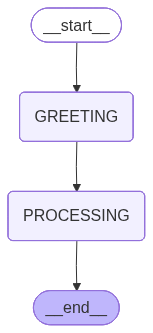

In [22]:
Image('hello_langgraph.png')

In [18]:
!pip install grandalf

  Using cached grandalf-0.8-py3-none-any.whl.metadata (1.7 kB)
Using cached grandalf-0.8-py3-none-any.whl (41 kB)



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
